# Polygon Generation using Genetic Algorithms & CSP

In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import shapely
from ground.base import get_context
from bentley_ottmann.planar import contour_self_intersects
from sympy import Point,Line,Polygon

In [2]:
def return_point(my_gene):
    mid=len(my_gene)/2
    point=[0,0]
    point[0]=to_decimal(my_gene[:int(mid)]) 
    point[1]=to_decimal(my_gene[int(mid):]) 
    return point

def to_binary(my_decimal,bits):
    my_binary=''
    for x in range(bits):
        my_binary+='0'
    my_index=bits

    while my_decimal>0 :   
        if my_decimal%2==0 : my_binary = my_binary[:my_index-1] + '0' + my_binary[my_index:]
        else : my_binary = my_binary[:my_index-1] + '1' + my_binary[my_index:]
        my_decimal/=2
        my_decimal=int(my_decimal)
        my_index-=1 
    return my_binary 

def to_decimal(my_binary):
    my_decimal=0
    my_index=len(my_binary)-1
    for x in range(len(my_binary)):
        my_decimal+=pow(2,my_index)*(int(my_binary[x]))
        my_index-=1
    return my_decimal

In [3]:
def generate_new_gene(bits):    
    my_gene=''
    my_rand1=random.randint(0,pow(2,bits)-1)
    my_rand2=random.randint(0,pow(2,bits)-1)
    my_point_1=to_binary(my_rand1,bits)
    my_point_2=to_binary(my_rand2,bits)
    my_gene=my_point_1+my_point_2
    return my_gene  

def duplicate_gene(my_points,my_temp_points,x):
    for i in range(x):
        if my_temp_points[0]==my_points[i][0] and my_temp_points[1]==my_points[i][1] : return True
    return False

def generate_new_chromosome(n,bits):
    my_chromosome=''
    my_points = np.arange(2*n).reshape(n,2)
    my_temp_points=[0,0]
    exists=True    
    for x in range(n):    
        exists=True    
        while exists :
            my_temp_gene=generate_new_gene(bits)
            my_temp_points=return_point(my_temp_gene)
            if not (duplicate_gene(my_points,my_temp_points,x)) : 
                exists=False
            else :
                exists=True      
        my_chromosome+=my_temp_gene
        
        my_points[x][0]=my_temp_points[0]
        my_points[x][1]=my_temp_points[1]
    return my_chromosome    


def generate_initial_population(n,bits,my_initial_population) :
    my_population = []
    for x in range(my_initial_population):
        my_population.append(generate_new_chromosome(n,bits))
    return my_population

In [4]:
def check_intersecting_edges(my_chromosome,n,bits):
    context = get_context()
    Point, Segment = context.point_cls, context.segment_cls

    my_index1=0
    my_index2=0
    my_temp_points=[0,0]
    my_points=[]
    for x in range(n):
        my_index2+=2*bits
        my_gene=my_chromosome[my_index1:my_index2]
        my_temp_points=return_point(my_gene)
        my_index1=my_index2
        my_points.append(Point(my_temp_points[0],my_temp_points[1]))    
        
    Contour = context.contour_cls
    my_polygon = Contour(my_points)
    return (contour_self_intersects(my_polygon))
   
def check_convex_angles(my_chromosome,n,bits):
    my_convex=0
    my_index1=0
    my_index2=0
    my_temp_points=[0,0]
    my_points=[]
    for x in range(n):
        my_index2+=2*bits
        my_gene=my_chromosome[my_index1:my_index2]
        my_temp_points=return_point(my_gene)
        my_index1=my_index2
        my_points.append(Point(my_temp_points[0],my_temp_points[1]))    

    t = tuple(my_points)
    poly = Polygon(*t)
    for x in range(n):
        if math.degrees(poly.angles[my_points[x]]) < 90 : my_convex+=1
    return my_convex,poly.is_convex()

def plot_polygon(my_chromosome,n,bits):
    my_index1=0
    my_index2=0
    my_points = np.arange(2*n).reshape(n,2)
    my_temp_points=[0,0]

    for x in range(n):
        my_index2+=2*bits
        my_gene=my_chromosome[my_index1:my_index2]
        my_temp_points=return_point(my_gene)
        my_index1=my_index2
        my_points[x][0]=my_temp_points[0]
        my_points[x][1]=my_temp_points[1]
    
    coord=list(my_points)
    coord.append(coord[0]) # repeat the first point to create a 'closed loop'
    xs, ys = zip(*coord) # create lists of x and y values
    plt.figure()
    plt.plot(xs,ys) 
    plt.show() 

In [5]:
def crossover(my_chromosome1, my_chromosome2):
    offspring1=''
    offspring2=''
    for x in range(len(my_chromosome1)):
        offspring1+=my_chromosome1[x]
        offspring2+=my_chromosome2[x]
        
    offspring1 = list(offspring1)
    offspring2 = list(offspring2)
    k = random.randint(0, 15)  
    for i in range(k, len(my_chromosome1)):
        offspring1[i], offspring2[i] = offspring2[i], offspring1[i]
    offspring1 = ''.join(offspring1)
    offspring2 = ''.join(offspring2)
    return offspring1, offspring2

def mutation(my_generation,my_initial_population):
    for x in range(my_initial_population):
        my_temp=''
        my_temp=my_generation[x]    
        for y in range(len(my_temp)):
            my_rand=random.randint(0,255)
            if y>0 and my_rand%2==0 and my_temp[y]=='1': 
                my_temp=my_temp[:y-1] + '0' + my_temp[y:]
            elif y>0 and my_rand%2==0 and my_temp[y]=='0': 
                my_temp=my_temp[:y-1] + '1' + my_temp[y:]
        my_generation[x]=my_temp
    return my_generation

def mutate_chromosome(my_chromosome):
    my_temp=''+my_chromosome
    for y in range(len(my_temp)):
        my_rand=random.randint(0,255)
        if y>0 and my_rand%2==0 and my_temp[y]=='1': 
            my_temp=my_temp[:y-1] + '0' + my_temp[y:]
        elif y>0 and my_rand%2==0 and my_temp[y]=='0': 
            my_temp=my_temp[:y-1] + '1' + my_temp[y:]
    return my_temp 

def sort_parallel_list(list1, list2):
    zipped_pairs = zip(list2, list1)
    z = [x for _, x in sorted(zipped_pairs)]
    return z

def return_generation_fitness(my_initial_population,my_generation,n,bits):
    my_fitnesses=[]
    for x in range(my_initial_population):
        my_fitnesses.append(fitness_function(my_generation[x],n,bits))
    return my_fitnesses  

def fitness_function(my_chromosome,n,bits) :
    edges_cost=check_intersecting_edges(my_chromosome,n,bits) 
    angle_cost,convex=check_convex_angles(my_chromosome,n,bits)
    my_fitness_value=1000*(edges_cost==1)+(convex==0)*(20*(n-angle_cost))+1
    return my_fitness_value

def roulette_wheel_selection(my_generation,my_fitnesses,my_initial_population):
    total_population_fitness = sum(my_fitnesses)
    chromosome_probabilities=[]
    for x in range(my_initial_population):
        my_proportion=float(my_fitnesses[x])/total_population_fitness
        chromosome_probabilities.append(my_proportion)
    my_generation=sort_parallel_list(my_generation,my_fitnesses)
    my_generation=my_generation[:int(my_initial_population/2)]
    #chromosome_probabilities = 1 - np.array(chromosome_probabilities)
    #return list(np.random.choice(my_generation,int(my_initial_population/2),chromosome_probabilities))
    return my_generation

def tranform_generation(selected_generation,n,bits,my_population_size):
    for x in range(my_population_size-1):
        my_chromosome1, my_chromosome2=selected_generation[x],selected_generation[x+1]
        my_offspring1,my_offspring2=crossover(my_chromosome1, my_chromosome2)
        if fitness_function(my_offspring1,n,bits)>=51 : my_offspring1=mutate_chromosome(my_offspring1)
        if fitness_function(my_offspring2,n,bits)>=51 : my_offspring2=mutate_chromosome(my_offspring2)
        selected_generation.append(my_offspring1) 
        selected_generation.append(my_offspring2)    
    return selected_generation

def goal_test(my_generation,my_fitnesses,my_initial_population):
    found=False
    my_min=100
    my_goal=my_generation[0]
    for x in range(my_initial_population):
        if my_fitnesses[x]==1 :
            found=True
            my_goal=my_generation[x]
            return found,my_goal
        elif my_fitnesses[x]<my_min :
            my_goal=my_generation[x]
            my_min=my_fitnesses[x]
            
    return found,my_goal

def GA_processing(n,bits,my_initial_population,max_generations):
    found_goal=False
    my_iteration=0
    while(not(found_goal) and my_iteration<max_generations):
        print("........................ Genetic Algorithm Running ........................")
        print("GA Iteration no # ",my_iteration+1)
        my_generation=generate_initial_population(n,bits,my_initial_population) 
        my_fitnesses=return_generation_fitness(my_initial_population,my_generation,n,bits)
        selected_generation=roulette_wheel_selection(my_generation,my_fitnesses,my_initial_population) 
        my_generation=tranform_generation(selected_generation,n,bits,int(my_initial_population/2))
        my_fitnesses=return_generation_fitness(my_initial_population,my_generation,n,bits)  
        found_goal , my_goal=goal_test(my_generation,my_fitnesses,my_initial_population)
        if found_goal==True :
            print("Non-Intersecting & Convex Polygon FOUND ")
            plot_polygon(my_goal,n,bits)
        else :
            print("Best Polygon of GA Iteration no # ",my_iteration+1," is : ")
            plot_polygon(my_goal,n,bits)
        my_iteration+=1

Enter value of n :- 
4
........................ Genetic Algorithm Running ........................
GA Iteration no #  1
Non-Intersecting & Convex Polygon FOUND 


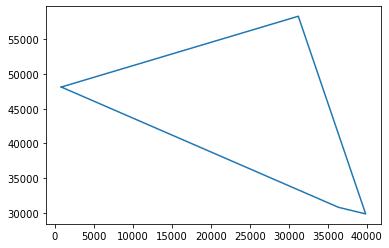

In [6]:
#Initial Population Size is 100 . So, my_initial_population=100
#The maxmimum coordinates which can be achieved is (255,255) . So, my_bits value is fixed to be 8

#Constraints
bits=16
my_initial_population=20
max_generations=10

print('Enter value of n :- ')
n = int(input())

GA_processing(n,bits,my_initial_population,max_generations)